# CS-433 Project 1: ML Higgs 
Changling Li, Julian Blackwell, Luca Bataillard

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [32]:
from proj1_helpers import *
from implementations import *

In [22]:
DATA_TRAIN_PATH = '../data/train.csv'
y_train, x_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
column_names = np.genfromtxt(DATA_TRAIN_PATH, delimiter=",", dtype=str)[0, 2:]

## Exploratory data analysis

We read appendix B of the original Higgs paper and discover several key points:

* The event label (string) $y_i \in \{s, b\}$ (s for signal, b for background)
* The variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
* The variables prefixed with DER (for DERived) are quantities computed from the primitive features
* Undefined values are denoted by -999.0, which is outside the normal range of all variables.
* All variables are floating point and continuous, apart from PRI_jet_num, which ranges in $\{0, 1, 2, 3\}$

We therefore begin our data analysis by doing same basic checks such as inspecting the `y` array of labels. According to the documentation, all labels are $-1$ for background 'b' and $1$ is for signal 's'. We check this below:

In [23]:
((y_train == 1) | (y_train == -1)).all()

True

We then inspected the size of the dataset which contains 250'000 data samples with 30 feature columns.

In [24]:
N, D = x_train.shape
print(f"Number of rows: {N}")
print(f"Number of columns: {D}")

Number of rows: 250000
Number of columns: 30


### Step 1: Inspecting the labels and the features

Then, we inspect the features of 'x_train' to confirm the previous claims. We can see that `PRI_jet_num` corresponds to column 22. We decide to do no further processing to this variable and treat it as continuous. We notice several undefined variables.

In [6]:
for i, colname in enumerate(column_names):
    col = x_train[:5, i]
    print(f"{i:2} - {colname:30s}: {col}")

 0 - DER_mass_MMC                  : [ 138.47   160.937 -999.     143.905  175.864]
 1 - DER_mass_transverse_met_lep   : [ 51.655  68.768 162.172  81.417  16.915]
 2 - DER_mass_vis                  : [ 97.827 103.235 125.953  80.943 134.805]
 3 - DER_pt_h                      : [27.98  48.146 35.635  0.414 16.405]
 4 - DER_deltaeta_jet_jet          : [ 9.10e-01 -9.99e+02 -9.99e+02 -9.99e+02 -9.99e+02]
 5 - DER_mass_jet_jet              : [ 124.711 -999.    -999.    -999.    -999.   ]
 6 - DER_prodeta_jet_jet           : [   2.666 -999.    -999.    -999.    -999.   ]
 7 - DER_deltar_tau_lep            : [3.064 3.473 3.148 3.31  3.891]
 8 - DER_pt_tot                    : [41.928  2.078  9.336  0.414 16.405]
 9 - DER_sum_pt                    : [197.76  125.157 197.814  75.968  57.983]
10 - DER_pt_ratio_lep_tau          : [1.582 0.879 3.776 2.354 1.056]
11 - DER_met_phi_centrality        : [ 1.396  1.414  1.414 -1.285 -1.385]
12 - DER_lep_eta_centrality        : [ 2.00e-01 -9.99e+02 -9.9

### Step 2: Summary statistics

By computing the summary statistics on the data, we notice that undefined values are not present in all columns. However, in columns where they are present, they comprise a large proportion of the data. There are too many such rows to be simply discarded as outliers, so we will treat them as regular datapoints for the time being.

We also notice that each feature follows a very different distribution. To ease model computational cost and improve model performance, we will scale the dataset by subtracting the mean and dividing by the standard deviation. 

In [7]:
display_summary_statistics(x_train, column_names=column_names)

   Column                      |   Mean   |  Median  | Std dev  |   Max    |    Min   | # Undefined | % Undef 
 0-DER_mass_MMC                |  -49.023    105.012    406.345   1192.026   -999.000    38114.000     15.246
 1-DER_mass_transverse_met_lep |   49.240     46.524     35.345    690.075      0.000        0.000      0.000
 2-DER_mass_vis                |   81.182     73.752     40.829   1349.351      6.329        0.000      0.000
 3-DER_pt_h                    |   57.896     38.468     63.656   2834.999      0.000        0.000      0.000
 4-DER_deltaeta_jet_jet        | -708.421   -999.000    454.480      8.503   -999.000   177457.000     70.983
 5-DER_mass_jet_jet            | -601.237   -999.000    657.971   4974.979   -999.000   177457.000     70.983
 6-DER_prodeta_jet_jet         | -709.357   -999.000    453.019     16.690   -999.000   177457.000     70.983
 7-DER_deltar_tau_lep          |    2.373      2.492      0.783      5.684      0.208        0.000      0.000
 8-DER_pt

### Step 3: Correlation between features

To check if there are obvious relationships or correlation between features, we plot a visual representation of the lower triangle of the (symmetric) Pearson correlation matrix. The triangle contains all the Pearson correlation coefficients which give a measure of linear correlation between features.

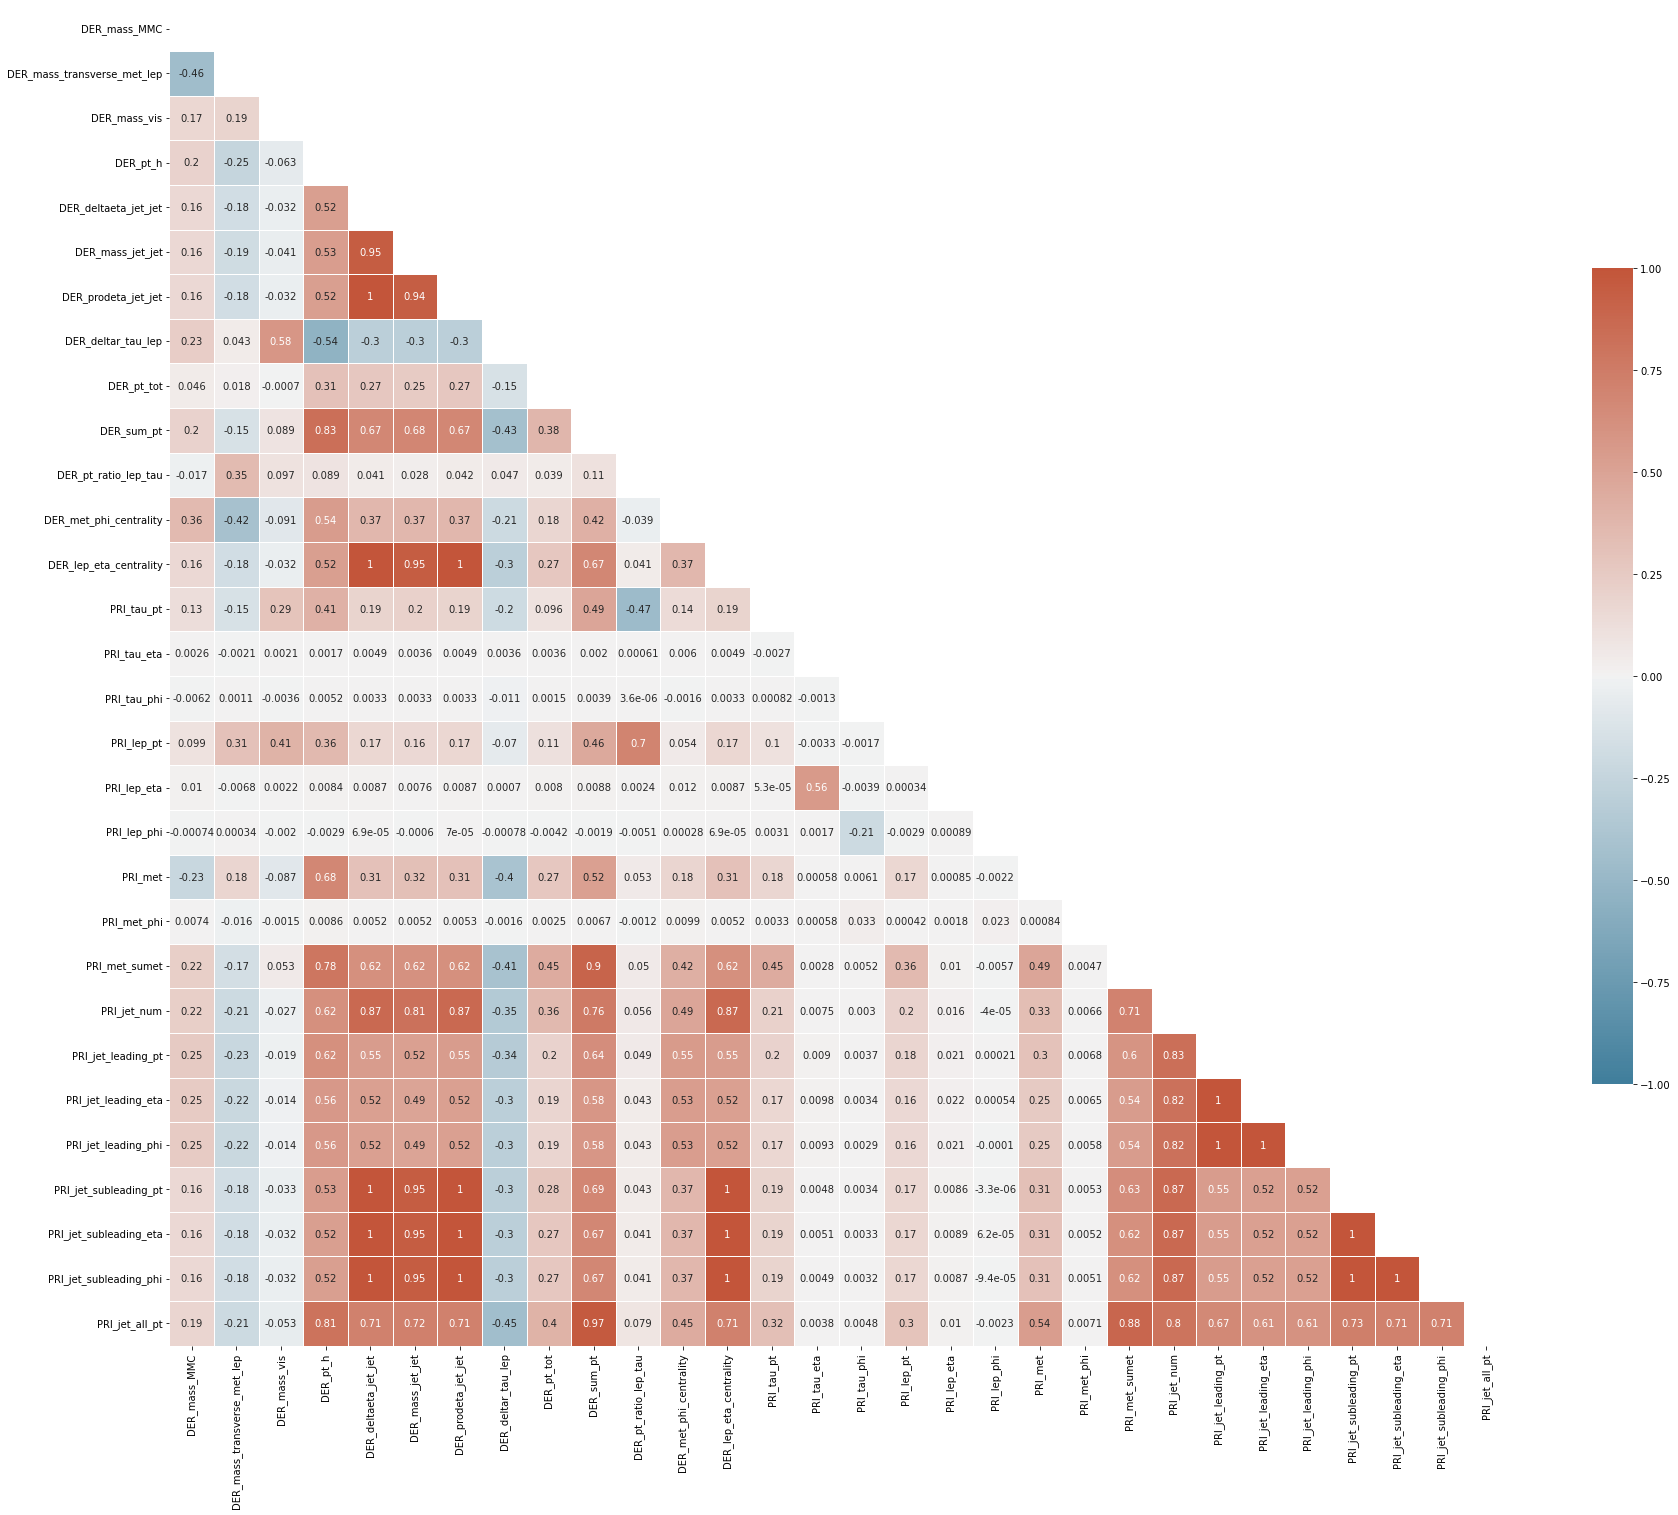

In [8]:
plot_corr_matrix(x_train, column_names)

## Feature processing

### Handling missing values

After initial data analysies, we notice that a small number of columns have over $70\%$ invalid values. We decide to discard such columns. 

Some other columns still have invalid values, we decide to replace the $-999$ by the mean of all non-invalid values in that column.

In [25]:
x_train, column_names = handle_invalid(x_train, column_names)

7 columns are above the invalid threshold. Removing
	DER_deltaeta_jet_jet
	DER_mass_jet_jet
	DER_prodeta_jet_jet
	DER_lep_eta_centrality
	PRI_jet_subleading_pt
	PRI_jet_subleading_eta
	PRI_jet_subleading_phi


### Removing correlated columns
Since we removed some features, we re-plot the correlation matrix. 

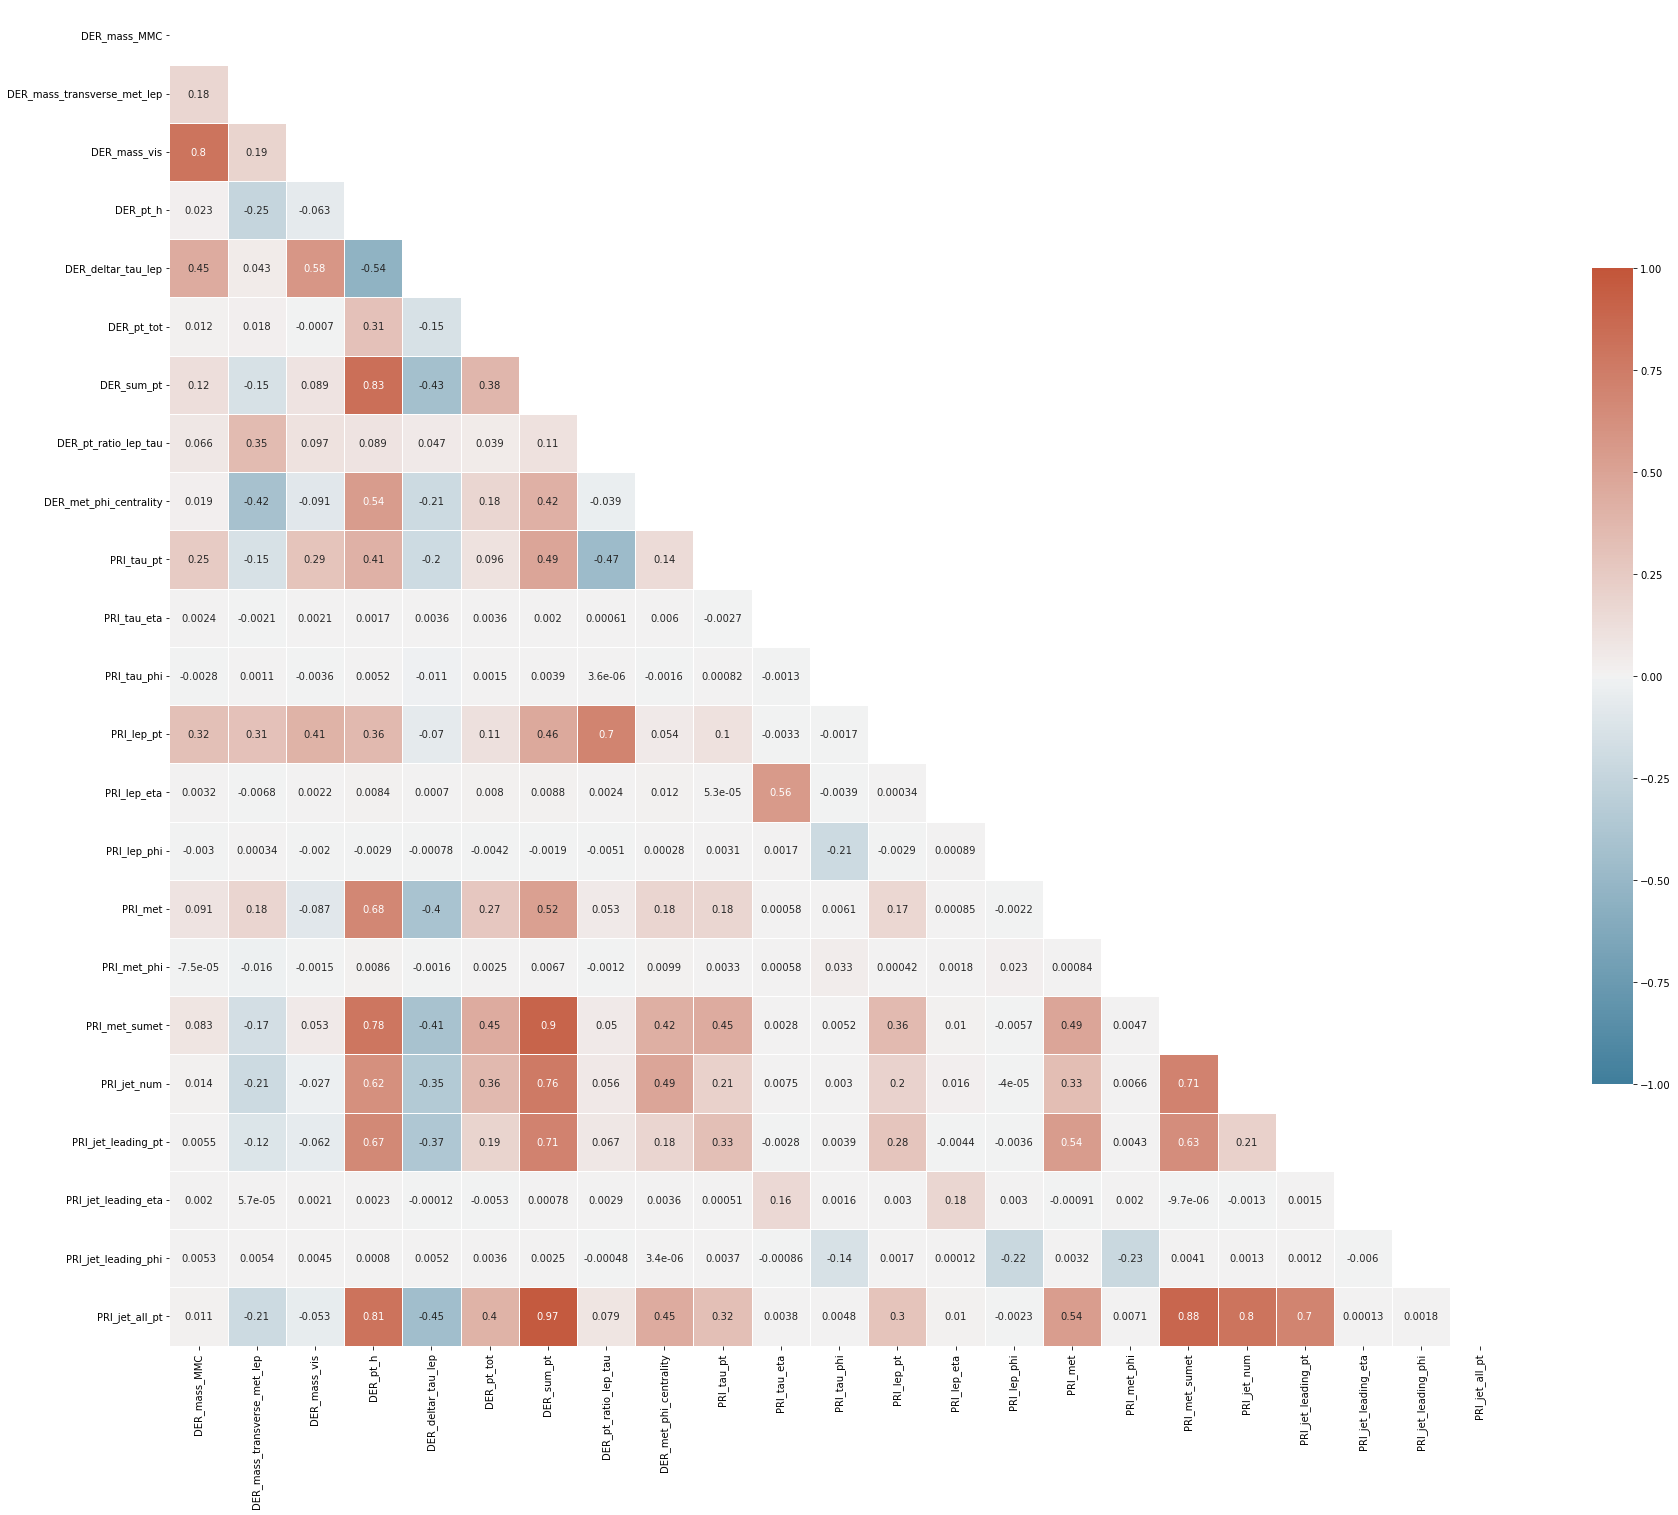

In [19]:
plot_corr_matrix(x_train, column_names)

We notice that a subset of columns are highly correlated to other so we decide to remove these as well.

In [26]:
to_remove = ['DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet', 'PRI_jet_all_pt', 'DER_mass_vis']
to_remove = [np.where(column_names == name)[0][0] for name in to_remove]
to_remove = np.array(to_remove)
x_train, column_names = remove_columns(x_train, to_remove), np.delete(column_names, to_remove)

Let's plot again the correlation matrix to check if there are still other high correlation coefficients.

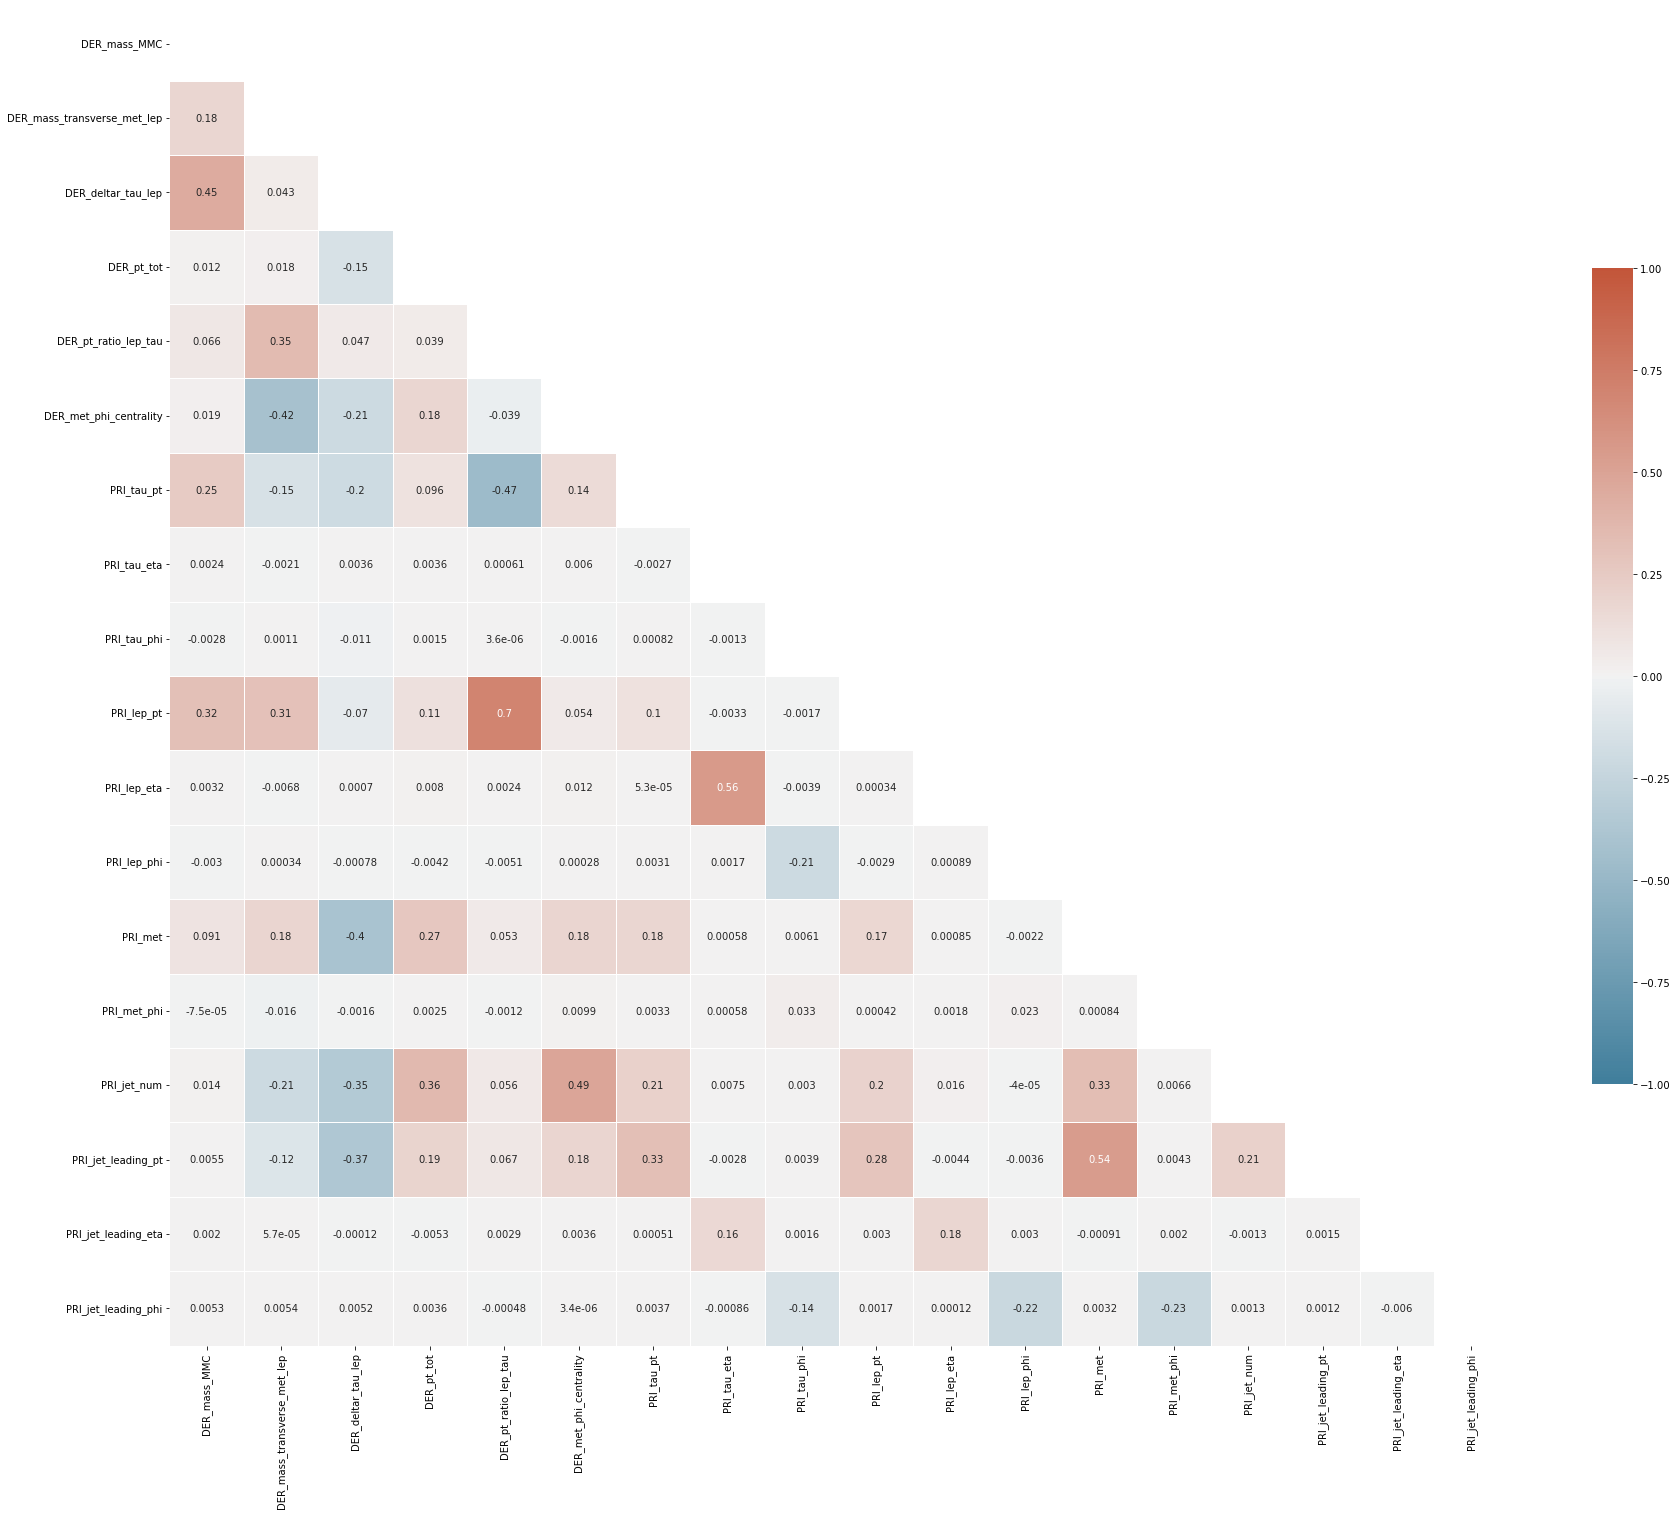

In [27]:
plot_corr_matrix(x_train, column_names)

### Removing outliers
We make our training data more robust by removing outliers in the data. We choose to remove all such data points which are 2 standard deviations further from the mean.

In [28]:
outlier_row_ids = set()
for i in range(x_train.shape[1]):
    outlier_row_ids.update(detect_outlier(x_train[:, i], 3))
    
x_outlier_free = np.delete(x_train, list(outlier_row_ids), axis=0)
y_outlier_free = np.delete(y_train, list(outlier_row_ids), axis=0)

The purcentage of data points we want to remove from the dataset is then :

In [54]:
print(len(outlier_row_ids) / x_train.shape[0], '%')

0.090744 %


### Feature expansion
Now that correlated columns and outliers have been removed, we decide to expand the features. We first add all pairwise multiplied columns as features

In [33]:
pairwise_poly = tuple([expand_poly(x_outlier_free, i) for i in range(1, 3)])
pairwise_poly = np.hstack(pairwise_poly)

In [41]:
# Check degree performance
for k in range(4, 15):
    col_polynomials = tuple([construct_poly(x_outlier_free, i) for i in range(3, k)])
    col_polynomials = np.hstack(col_polynomials)
    x_expanded = np.hstack((pairwise_poly, col_polynomials))
    x_expanded, _, _ = standardize(x_expanded)
    print('Degree : ', k-1, ' - ', cross_val_acc(y_outlier_free, x_expanded))

Degree :  3  -  0.7609432053143286
Degree :  4  -  0.7726760811226959
Degree :  5  -  0.7722361532708636
Degree :  6  -  0.7771149531476836
Degree :  7  -  0.7786063085653951
Degree :  8  -  0.7794729664335049
Degree :  9  -  0.7802032466675466
Degree :  10  -  0.7800800668690335
Degree :  11  -  0.7803572214156878
Degree :  12  -  0.7804408077075359
Degree :  13  -  0.7802164445031016


We then add polynomials of higher order of all columns ($X^3$, $X^4$, ... upto $X^{12}$)

In [42]:
col_polynomials = tuple([construct_poly(x_outlier_free, i) for i in range(3, 13)])
col_polynomials = np.hstack(col_polynomials)
x_expanded = np.hstack((pairwise_poly, col_polynomials))

## Model selection
Now that the data has been appropriately engineered, we decide to try out several models. When appropriate, we perform hyperparameter search using grid search and $5$-fold cross validation.


In [44]:
x_expanded_std, x_exp_mean, x_exp_std = standardize(x_expanded)

### Least squares using gradient descent

In [48]:
least_squares_GD_params = {
    'max_iters': [30],
    'gamma': [0.2, 0.1, 0.001, 0.0001, 0.00001, 0.0000000347]
}
best_least_square_GD_params = parameter_grid_search(y_outlier_free, x_expanded_std, least_squares_GD, compute_rmse,
                                            ff_params=least_squares_GD_params, 
                                            verbose=True, initial_w=np.zeros(x_expanded_std.shape[1]))[0]['params']
best_least_square_GD_params

Parameter combination 0:
	Params: {'max_iters': 30, 'gamma': 0.2}
	Score: 6.842342419583538e+20
Parameter combination 1:
	Params: {'max_iters': 30, 'gamma': 0.1}
	Score: 1192461524.0755563
Parameter combination 2:
	Params: {'max_iters': 30, 'gamma': 0.001}
	Score: 0.9369547243807391
Parameter combination 3:
	Params: {'max_iters': 30, 'gamma': 0.0001}
	Score: 0.9904756917157351
Parameter combination 4:
	Params: {'max_iters': 30, 'gamma': 1e-05}
	Score: 0.9990010153434857
Parameter combination 5:
	Params: {'max_iters': 30, 'gamma': 3.47e-08}
	Score: 0.9999965148977668


{'max_iters': 30, 'gamma': 0.001}

### Least squares using stochastic gradient descent

In [50]:
least_squares_SGD_params = {
    'max_iters': [30],
    'gamma': [0.001, 0.0001, 0.00001, 0.000001, 0.0000000347]
}
best_least_square_SGD_params = parameter_grid_search(y_outlier_free, x_expanded_std, least_squares_SGD, compute_rmse,
                                            ff_params=least_squares_SGD_params, 
                                             verbose=True, initial_w=np.zeros(x_expanded_std.shape[1]))[0]['params']
best_least_square_SGD_params

Parameter combination 0:
	Params: {'max_iters': 30, 'gamma': 0.001}
	Score: 2.7253584298223217
Parameter combination 1:
	Params: {'max_iters': 30, 'gamma': 0.0001}
	Score: 1.0114452952426567
Parameter combination 2:
	Params: {'max_iters': 30, 'gamma': 1e-05}
	Score: 1.000491104075687
Parameter combination 3:
	Params: {'max_iters': 30, 'gamma': 1e-06}
	Score: 1.0000426687685318
Parameter combination 4:
	Params: {'max_iters': 30, 'gamma': 3.47e-08}
	Score: 1.0000014566525393


{'max_iters': 30, 'gamma': 3.47e-08}

### Least squares

In [51]:
best_least_squares_params = parameter_grid_search(y_outlier_free, x_expanded_std, least_squares, compute_rmse, verbose=True)[0]["params"]
best_least_squares_params

Parameter combination 0:
	Params: {}
	Score: 0.8042324179142357


{}

### Logistic regression using gradient descent

In [53]:
logistic_regression_params = {
    'max_iters': [30],
    'gamma': [0.9999, 0.999, 0.99, 0.9, 0.0000000347],
}

best_logistic_params = parameter_grid_search(y_outlier_free, x_expanded_std, logistic_regression, compute_logistic_loss,
                                            ff_params=logistic_regression_params, 
                                             verbose=True, initial_w=np.zeros(x_expanded_std.shape[1]))[0]['params']
best_logistic_params

Parameter combination 0:
	Params: {'max_iters': 30, 'gamma': 0.9999}
	Score: -3.032941633856769
Parameter combination 1:
	Params: {'max_iters': 30, 'gamma': 0.999}
	Score: -3.0302967926452653
Parameter combination 2:
	Params: {'max_iters': 30, 'gamma': 0.99}
	Score: -3.0038507766055003
Parameter combination 3:
	Params: {'max_iters': 30, 'gamma': 0.9}
	Score: -2.7396392694364713
Parameter combination 4:
	Params: {'max_iters': 30, 'gamma': 3.47e-08}
	Score: 0.6931436962773473


{'max_iters': 30, 'gamma': 0.9999}

### Logistic regression using stochastic gradient descent

In [56]:
logistic_regression_SGD_params = {
    'max_iters': [30],
    'gamma': [0.9999, 0.999, 0.99, 0.9, 0.0000000347],
}

best_logistic_SGD_params = parameter_grid_search(y_outlier_free, x_expanded_std, logistic_regression_SGD, compute_logistic_loss,
                                            ff_params=logistic_regression_SGD_params, 
                                             verbose=True, initial_w=np.zeros(x_expanded_std.shape[1]))[0]['params']
best_logistic_SGD_params

Parameter combination 0:
	Params: {'max_iters': 30, 'gamma': 0.9999}
	Score: 3.791481750194343e+45
Parameter combination 1:
	Params: {'max_iters': 30, 'gamma': 0.999}
	Score: 3.692381097565511e+45
Parameter combination 2:
	Params: {'max_iters': 30, 'gamma': 0.99}
	Score: 2.8295588780419272e+45
Parameter combination 3:
	Params: {'max_iters': 30, 'gamma': 0.9}
	Score: 1.7199587594883733e+44
Parameter combination 4:
	Params: {'max_iters': 30, 'gamma': 3.47e-08}
	Score: 0.693149199548032


{'max_iters': 30, 'gamma': 3.47e-08}

### Regularized logistic regression

In [57]:
reg_logistic_regression_params = {
    'max_iters': [30],
    'gamma': [0.9999, 0.999, 0.99, 0.9, 0.0000000347],
    'lambda_': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
}

best_reg_logistic_params = parameter_grid_search(y_outlier_free, x_expanded_std, reg_logistic_regression, compute_logistic_loss,
                                            ff_params=reg_logistic_regression_params, 
                                             verbose=True, initial_w=np.zeros(x_expanded_std.shape[1]))[0]['params']
best_reg_logistic_params

Parameter combination 0:
	Params: {'max_iters': 30, 'gamma': 0.9999, 'lambda_': 0.01}
	Score: -2.2181716772115747
Parameter combination 1:
	Params: {'max_iters': 30, 'gamma': 0.9999, 'lambda_': 0.02}
	Score: -1.670106830337692
Parameter combination 2:
	Params: {'max_iters': 30, 'gamma': 0.9999, 'lambda_': 0.03}
	Score: -1.2948600009971774
Parameter combination 3:
	Params: {'max_iters': 30, 'gamma': 0.9999, 'lambda_': 0.04}
	Score: -1.0324947235300077
Parameter combination 4:
	Params: {'max_iters': 30, 'gamma': 0.9999, 'lambda_': 0.05}
	Score: -0.8445861451942225
Parameter combination 5:
	Params: {'max_iters': 30, 'gamma': 0.9999, 'lambda_': 0.06}
	Score: -0.7063639341051318
Parameter combination 6:
	Params: {'max_iters': 30, 'gamma': 0.999, 'lambda_': 0.01}
	Score: -2.216822156283735
Parameter combination 7:
	Params: {'max_iters': 30, 'gamma': 0.999, 'lambda_': 0.02}
	Score: -1.6694380175766756
Parameter combination 8:
	Params: {'max_iters': 30, 'gamma': 0.999, 'lambda_': 0.03}
	Score:

{'max_iters': 30, 'gamma': 0.9999, 'lambda_': 0.01}

### Ridge regression

We now select our model which will be ridge regression. We perform grid search and 5-fold cross-validation to optimize our hyperparameters to find the best training weights. The other implementations of ML methods are down below.

We start off with ridge regression:

In [60]:
ridge_regression_params = {
    "lambda_": [1e-02, 1e-03, 5e-05, 2e-05, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09],
}

best_ridge_params = parameter_grid_search(y_outlier_free, x_expanded_std, ridge_regression, compute_rmse, 
                                    ff_params=ridge_regression_params, verbose=False)[0]["params"]
print(best_ridge_params)

{'lambda_': 1e-09}


### Retrain best performing model
We have now found the best performing models with reasonably good hyperparameters. We will retrain these models on the entire training dataset before choosing the best among the best ones, then generate predictions for the test dataset.

In [77]:
def cross_val_acc(y, tx, fit_fct, k_fold=10, eval_=eval_performance, seed = 1, **fit_fct_args):
    k_indices = build_k_indices(y, k_fold, seed)
    score_te = 0

    for k in range(k_fold):
        te_indices = k_indices[k]
        tr_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)

        y_te, x_te = y[te_indices], tx[te_indices]
        y_tr, x_tr = y[tr_indices], tx[tr_indices]

        w, fit_loss = fit_fct(y_tr, x_tr, **fit_fct_args)
        score_te += eval_(w, y_te, x_te)

    return score_te/k_fold

best_least_square_GD_params.update({'initial_w': np.zeros(x_expanded_std.shape[1])}) 
best_least_square_SGD_params.update({'initial_w': np.zeros(x_expanded_std.shape[1])}) 
best_logistic_params.update({'initial_w': np.zeros(x_expanded_std.shape[1])})
best_logistic_SGD_params.update({'initial_w': np.zeros(x_expanded_std.shape[1])}) 
best_reg_logistic_params.update({'initial_w': np.zeros(x_expanded_std.shape[1])}) 

best_params = [(least_squares_GD, best_least_square_GD_params), 
           (least_squares_SGD, best_least_square_SGD_params), 
           (least_squares, {}), 
           (logistic_regression, best_logistic_params), 
           (logistic_regression_SGD, best_logistic_SGD_params), 
           (reg_logistic_regression, best_reg_logistic_params), 
           (ridge_regression, best_ridge_params)]

for model, params in best_params:
    accuracy = cross_val_acc(y_outlier_free, x_expanded_std, fit_fct = model, **params)
    print('{} : {}'.format(model, accuracy))

<function least_squares_GD at 0x7fbaadedeca0> : 0.7033170560028156
<function least_squares_SGD at 0x7fbaadedec10> : 0.44555892833575295
<function least_squares at 0x7fbaadeded30> : 0.7803660199727245
<function logistic_regression at 0x7fbaadedee50> : 0.7343363688355109
<function logistic_regression_SGD at 0x7fbaadedeee0> : 0.44555892833575295
<function reg_logistic_regression at 0x7fbaadedef70> : 0.7343803616206942
<function ridge_regression at 0x7fbaadededc0> : 0.7792178082794421


We now select our model which will be ridge regression. We perform grid search and 5-fold cross-validation to optimize our hyperparameters to find the best training weights. The other implementations of ML methods are down below.

We start off with ridge regression:

In [78]:
# Retrain model with entire dataset
submit_weights, _ = ridge_regression(y_outlier_free, x_expanded_std, **best_ridge_params)

### Creating submission

In [79]:
DATA_TEST_PATH = '../data/test.csv'
_, x_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [80]:
x_test, _ = handle_invalid(x_test)

7 columns are above the invalid threshold. Removing
	

In [81]:
# Remove correlated columns
x_test = remove_columns(x_test, to_remove)

In [82]:
# Feature expansion
pairwise_poly = tuple([expand_poly(x_test, i) for i in range(1, 3)])
pairwise_poly = np.hstack(pairwise_poly)

col_polynomials = tuple([construct_poly(x_test, i) for i in range(3, 13)])
col_polynomials = np.hstack(col_polynomials)
x_expanded = np.hstack((pairwise_poly, col_polynomials))

In [83]:
# Standardize
x_test_std, _, _ = standardize(x_expanded, x_exp_mean, x_exp_std)

In [84]:
# Predict labels and create submission
OUTPUT_PATH = '../output/test_pred.csv'
y_pred = predict_labels(submit_weights, x_test_std)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)